In [208]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Polygon, Point, LinearRing, box
import seaborn as sns; sns.set()
import math
%matplotlib notebook

In [224]:
# poly = Polygon([[3750901.5068, -19268905.6133], [3750901.5068,-19208905.6133],
#                 [3770901.5068, -19268905.6133], [3770901.5068,-19208905.6133]])
poly = box(3750901.5068,-19268905.6133, 3770901.5068, -19208905.6133)

# def city_distance(x, y):
#     if ((x >= 3750901.5068) & (x <= 3770901.5068) & (y >= -19268905.6133) & (y <= -19208905.6133)):
#         return 0.0
#     else:
#         point = Point(x, y)
#         pol_ext = LinearRing(poly.exterior.coords)
#         d = pol_ext.project(point)
#         p = pol_ext.interpolate(d)
#         closest_point_coords = list(p.coords)[0]
        
#         return point.distance(Point(closest_point_coords))

def city_distance(x, y):
    if ((x >= 3750901.5068) & (x <= 3770901.5068) & (y >= -19268905.6133) & (y <= -19208905.6133)):
        point = Point(x, y)
        pol_ext = LinearRing(poly.exterior.coords)
        d = pol_ext.project(point)
        p = pol_ext.interpolate(d)
        closest_point_coords = list(p.coords)[0]
        
        return -point.distance(Point(closest_point_coords))
    else:
        point = Point(x, y)
        pol_ext = LinearRing(poly.exterior.coords)
        d = pol_ext.project(point)
        p = pol_ext.interpolate(d)
        closest_point_coords = list(p.coords)[0]
        
        return point.distance(Point(closest_point_coords))

In [118]:
df_train = pd.read_csv("../../data/data_train.csv")
df_test = pd.read_csv("../../data/data_test.csv")
df_train['time_entry'] = pd.to_timedelta(df_train['time_entry'])
df_train['time_exit'] = pd.to_timedelta(df_train['time_exit'])
df_test['time_entry'] = pd.to_timedelta(df_test['time_entry'])
df_test['time_exit'] = pd.to_timedelta(df_test['time_exit'])
df_train['duration'] = df_train['time_exit'] - df_train['time_entry']
df_train['duration'] = df_train['duration'].dt.total_seconds()
df_test['duration'] = df_test['time_exit'] - df_test['time_entry']
df_test['duration'] = df_test['duration'].dt.total_seconds()
df_train['distance'] = df_train.apply(lambda row: Point(row['x_entry'],row['y_entry']).
                                      distance(Point(row['x_exit'],row['y_exit'])), axis=1)
df_train['velocity'] = df_train.apply(lambda row: (row['distance']/row['duration'])
                                      if row['duration']!= 0.0 else 0.0, axis=1)

In [119]:
df_test['city_distance'] = df_test.apply(lambda row: city_distance(row['x_entry'], row['y_entry']), axis = 1)
df_train['city_distance'] = df_train.apply(lambda row: city_distance(row['x_entry'], row['y_entry']), axis = 1)
print("*****City Distance done*****")
df_train['ratio'] = df_train.apply(lambda row: (row['city_distance']/row['duration'])
                                      if row['duration']!= 0.0 else 0.0, axis=1)
df_test['ratio'] = df_test.apply(lambda row: (row['city_distance']/row['duration'])
                                      if row['duration']!= 0.0 else 0.0, axis=1)
print("*****Ratio done*****")
df_train['label']= -1
df_train['label'] = df_train.apply(lambda row: 1 
                                 if ((row['x_exit'] >= 3750901.5068) & (row['x_exit'] <= 3770901.5068) & 
                                     (row['y_exit'] >= -19268905.6133) & (row['y_exit'] <= -19208905.6133)) 
                                 else 0, axis=1)
df_test['label']= -1
df_test['label'] = df_test.apply(lambda row: 1 
                                 if ((row['duration'] == 0.0)&(math.isnan(row['x_exit'])) & (math.isnan(row['y_exit'])) &
                                      (row['x_entry'] >= 3750901.5068) & (row['x_entry'] <= 3770901.5068) & 
                                      (row['y_entry'] >= -19268905.6133) & (row['y_entry'] <= -19208905.6133)) 
                                 else row['label'], axis=1)
df_test['label'] = df_test.apply(lambda row: 0 
                                 if ((row['duration'] == 0.0)&(math.isnan(row['x_exit'])) & (math.isnan(row['y_exit'])) &
                                     (row['label'] == -1))
                                 else row['label'], axis=1)
print("*****Label done*****")

*****City Distance done*****
*****Ratio done*****
*****Label done*****


In [8]:
df_train.to_pickle('df_train')
df_test.to_pickle('df_test')

In [120]:
test = df_test[(df_test['duration'] != 0.0) & (df_test.x_exit.isnull()) & (df_test.y_exit.isnull())]
start_time = '0 days 15:00:00'
end_time = '0 days 16:00:00'
dd = df_train[(df_train['time_exit'] >= start_time) & (df_train['time_exit'] <= end_time)]
dd[(dd['duration'] == 0.0) & (dd['x_exit'] >= 3750901.5068) & 
         (dd['x_exit'] <= 3770901.5068) & (dd['y_exit'] >= -19268905.6133) & 
         (dd['y_exit'] <= -19208905.6133)].label.value_counts()
dd[(dd['duration'] == 0.0) & ((dd['x_exit'] < 3750901.5068) | 
         (dd['x_exit'] > 3770901.5068)) & ((dd['y_exit'] < -19268905.6133) | 
         (dd['y_exit'] > -19208905.6133))].label.value_counts()
dd_1 = dd[(dd['duration'] != 0.0) & (dd['x_exit'] >= 3750901.5068) & 
         (dd['x_exit'] <= 3770901.5068) & (dd['y_exit'] >= -19268905.6133) & 
         (dd['y_exit'] <= -19208905.6133)]
train = dd[dd['duration'] != 0.0]

In [10]:
train.to_pickle('train')
test.to_pickle('test')

In [12]:
df = df_train.groupby('hash')
df_list = list(df)
df_2 = df_test.groupby('hash')
df_2_list = list(df_2)
df_list.to_pickle('df_list')
df_2_list.to_pickle('df_2_list')

AttributeError: 'list' object has no attribute 'to_pickle'

In [ ]:
df_train = pd.read_pickle('df_train')
df_train = pd.read_pickle('df_train')
train = pd.read_pickle('train')
test = pd.read_pickle('test')
df_list = pd.read_pickle('df_list')
df_2_list = pd.read_pickle('df_2_list')

In [ ]:
tt = df_train[(df_train['x_exit'] >= 3750901.5068) & (df_train['x_exit'] <= 3770901.5068) & 
              (df_train['y_exit'] >= -19268905.6133) & (df_train['y_exit'] <= -19208905.6133)]
tt2 = df_test[(df_test['x_exit'] >= 3750901.5068) & (df_test['x_exit'] <= 3770901.5068) & 
              (df_test['y_exit'] >= -19268905.6133) & (df_test['y_exit'] <= -19208905.6133)]

# Plottings

In [ ]:
def plot_trajectory(df_sample):
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                             (- 19268905.6133 + 19208905.6133),
                             linewidth=1,edgecolor='g',fill = False,hatch = '\\\\\\', label = 'city center')
    city = plt.gca().add_patch(rect)
    for index, row in df_sample.iterrows():
#         lines = plt.plot(df_sample.x_exit,df_sample.y_exit, label='Lines', color = 'g')
        arrows = plt.arrow(row['x_entry'], row['y_entry'], row['x_exit'] - row['x_entry'], row['y_exit'] - row['y_entry'],
                  label ='Trajectory', color = 'b')
    entries = plt.scatter(df_sample.x_entry,df_sample.y_entry, label='Entry point', color = 'b')
    exits = plt.scatter(df_sample.x_exit,df_sample.y_exit, label='Exit point', color = 'r')
#     lines = plt.plot(df_sample.x_exit,df_sample.y_exit, label='Lines', color = 'g')
    plt.legend(handles=[city, arrows])
    plt.grid(True)
    plt.show()

In [272]:
def plot_fig(train):
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                                 (- 19268905.6133 + 19208905.6133),
                                 linewidth=1,edgecolor='g',fill = False,hatch = '\\\\\\', label = 'city center')
    entries = plt.scatter(train.x_entry,train.y_entry, label='Entry point', color = 'b', s = 0.005)
#     exits = plt.scatter(train.x_exit,train.y_exit, label='Exit point', color = 'r', s = 0.005)
#     for index, row in train.iterrows():
#         arrows = plt.arrow(row['x_entry'], row['y_entry'], row['x_exit'] - row['x_entry'], row['y_exit'] - row['y_entry'],
#                   label ='Not in City', color = 'b', linewidth = 0.01)
    city = plt.gca().add_patch(rect)
    plt.legend(handles = [city])
    plt.title("Not in city journeys")
    plt.grid(True)
#     plt.savefig('foo.png', dpi=1200)
    plt.show()

In [ ]:
def plot_test_fig(sample):
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                                 (- 19268905.6133 + 19208905.6133),
                                 linewidth=1,edgecolor='g',fill = False,hatch = '\\\\\\', label = 'city center')
    entries = plt.scatter(sample.x_entry,sample.y_entry, label='Entry point', color = 'b', s = 0.002)
    city = plt.gca().add_patch(rect)
    plt.legend(handles = [city,entries])
    plt.title("All test starting point in map")
    plt.grid(True)
    plt.savefig('foo1.png', dpi=1200)
    plt.show()

In [ ]:
plot_trajectory(df_list[100][1])

In [32]:
def plot_point(row):
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                             (- 19268905.6133 + 19208905.6133),
                             linewidth=1,edgecolor='g',fill = False,hatch = '\\\\\\', label = 'city center')
    city = plt.gca().add_patch(rect)
    entries = plt.scatter(row['x_entry'],row['y_entry'], label='Entry point', color = 'b')
    plt.legend(handles=[city, entries])
    plt.grid(True)
    plt.show()

# Test Explore

In [ ]:
df_test[(df_test.x_exit.isnull()) & (df_test.y_exit.isnull())].duration.describe()

In [ ]:
df_test[(df_test['duration'] > 0) & (df_test['duration'] < 5000) & (df_test.x_exit.isnull()) & (df_test.y_exit.isnull())].duration.describe()

In [ ]:
plt.scatter(df_train[df_train['velocity'] != 0.0].distance, df_train[df_train['velocity'] != 0.0].duration)

In [ ]:
df_test[df_test.x_exit.isnull()]['label'].value_counts()

In [ ]:
df_test['label'] = df_test['label'].replace(-1,0)

In [ ]:
df_test[df_test.x_exit.isnull()][['trajectory_id', 'label']].to_csv('output.csv', index=False)

# Train explore

In [ ]:
df_train[(df_train['duration'] == 0.0) & ((df_train['x_entry'] != df_train['x_exit']) |
         (df_train['y_entry'] != df_train['y_exit']))]

In [ ]:
df_train[(df_train['duration'] == 0.0) & (df_train['x_entry'] == df_train['x_exit']) &
         (df_train['y_entry'] == df_train['y_exit'])].shape[0]

In [ ]:
df_train.label.value_counts()

In [ ]:
df_train[(df_train['duration'] == 0.0) & (df_train['x_exit'] >= 3750901.5068) & 
         (df_train['x_exit'] <= 3770901.5068) & (df_train['y_exit'] >= -19268905.6133) & 
         (df_train['y_exit'] <= -19208905.6133)]

# Explorations

In [ ]:
ax = sns.scatterplot(x="duration", y="city_distance", hue = 'label', data=dd[(dd['duration']!=0)&(dd['label'] == 1)])

In [ ]:
plt.clf()
plot_trajectory(dd_1)

In [ ]:
plt.clf()
plot_fig(train[train['label'] == 0])

In [ ]:
plt.clf()
plot_test_fig(df_test[(df_test['duration'] > 0) & (df_test.x_exit.isnull()) & (df_test.y_exit.isnull())])

In [ ]:
plt.scatter(df_train[df_train['duration']!= 0.0].duration, df_train[df_train['duration']!= 0.0].distance,
            label='Entry point', color = 'b', s= 0.01)

In [ ]:
plt.clf()
df_train[(df_train['velocity'] != 0.0)&(df_train['velocity'] < 100.0)].velocity.hist()

In [ ]:
plt.scatter(test.city_distance, test.duration, color = 'b', s = 0.01)

In [ ]:
plt.clf()
plt.scatter(train[train['label'] == 0].city_distance, train[train['label'] == 0].duration, color = 'r', s = 0.0001)
plt.scatter(train[train['label'] == 1].city_distance, train[train['label'] == 1].duration, color = 'b', s = 0.0001)

In [ ]:
ax = sns.scatterplot(x="city_distance", y="duration", hue = 'label', data=train, s=5)

In [161]:
train[(train['x_entry'] >= 3750901.5068) & 
         (train['x_entry'] <= 3770901.5068) & (train['y_entry'] >= -19268905.6133) & 
         (train['y_entry'] <= -19208905.6133)&(train['label'] == 1)].duration.describe()

count    12911.000000
mean       632.432112
std        669.635610
min          1.000000
25%        253.000000
50%        434.000000
75%        785.000000
max      14687.000000
Name: duration, dtype: float64

In [165]:
train[((train['x_entry'] < 3750901.5068) | 
         (train['x_entry'] > 3770901.5068)) & ((train['y_entry'] < -19268905.6133) |
         (train['y_entry'] > -19208905.6133)) &(train['label'] == 1)].sort_values('city_distance', ascending=False)

,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,duration,distance,velocity,city_distance,ratio,label
266171,266171,5374af4c0ae7a73e256fbde1b7b6eda8_25,traj_5374af4c0ae7a73e256fbde1b7b6eda8_25_22,14:31:34,15:31:36,NaN,NaN,NaN,3.771776e+06,-1.907794e+07,3.758998e+06,-1.922849e+07,3602.0,151089.110771,41.945894,130967.078002,36.359544,1
244017,244017,4c84d9ecad8d87846f85de5dd0cf0c89_19,traj_4c84d9ecad8d87846f85de5dd0cf0c89_19_4,15:14:07,15:39:00,NaN,NaN,NaN,3.773444e+06,-1.907956e+07,3.761113e+06,-1.923261e+07,1493.0,153539.953663,102.839889,129367.020676,86.649043,1
729481,729481,e5c74f71105abc53fd0999b519a97ec9_19,traj_e5c74f71105abc53fd0999b519a97ec9_19_12,15:10:01,15:44:33,NaN,NaN,NaN,3.773436e+06,-1.907965e+07,3.758439e+06,-1.924420e+07,2072.0,165232.724882,79.745524,129277.989964,62.392852,1
673093,673093,d398a52b217478778609a5e1a87e1e80_1,traj_d398a52b217478778609a5e1a87e1e80_1_5,15:03:03,15:21:10,NaN,NaN,NaN,3.773436e+06,-1.907973e+07,3.754619e+06,-1.924001e+07,1087.0,161379.506501,148.463207,129200.220871,118.859449,1
265210,265210,5322597f7f4a9d9ceea52f70a0c36621_1,traj_5322597f7f4a9d9ceea52f70a0c36621_1_2,15:29:40,15:46:52,NaN,NaN,NaN,3.773429e+06,-1.908040e+07,3.762241e+06,-1.921882e+07,1032.0,138872.483689,134.566360,128533.459167,124.547926,1
727029,727029,e4f430d932639825f787433044e37687_9,traj_e4f430d932639825f787433044e37687_9_3,14:35:43,15:15:56,NaN,NaN,NaN,3.773388e+06,-1.908044e+07,3.757547e+06,-1.926297e+07,2413.0,183218.358548,75.929697,128488.211062,53.248326,1
581293,581293,b6c094603abd99b66345280f0db07f0a_23,traj_b6c094603abd99b66345280f0db07f0a_23_0,15:25:31,15:35:28,NaN,NaN,NaN,3.773422e+06,-1.908055e+07,3.763553e+06,-1.921953e+07,597.0,139330.980522,233.385227,128377.770851,215.038142,1
187683,187683,3ae1d3f0036f480844803a151edc377e_19,traj_3ae1d3f0036f480844803a151edc377e_19_3,15:06:35,15:46:12,0.770000,0.770000,0.770000,3.773560e+06,-1.908064e+07,3.758409e+06,-1.923649e+07,2377.0,156582.726634,65.874096,128291.666032,53.972093,1
62822,62822,1391e4edf2ff61d9aa702bb6f81a0f9f_31,traj_1391e4edf2ff61d9aa702bb6f81a0f9f_31_12,15:06:12,15:30:08,NaN,NaN,NaN,3.773324e+06,-1.908126e+07,3.760129e+06,-1.923773e+07,1436.0,157022.312513,109.347014,127664.708562,88.903000,1
292609,292609,5be6ecc90eabe43ca9f9dc27e89e0164_5,traj_5be6ecc90eabe43ca9f9dc27e89e0164_5_6,14:50:14,15:48:39,NaN,NaN,NaN,3.773251e+06,-1.908256e+07,3.760563e+06,-1.923499e+07,3505.0,152949.238809,43.637443,126363.002145,36.052212,1


<IPython.core.display.Javascript object>


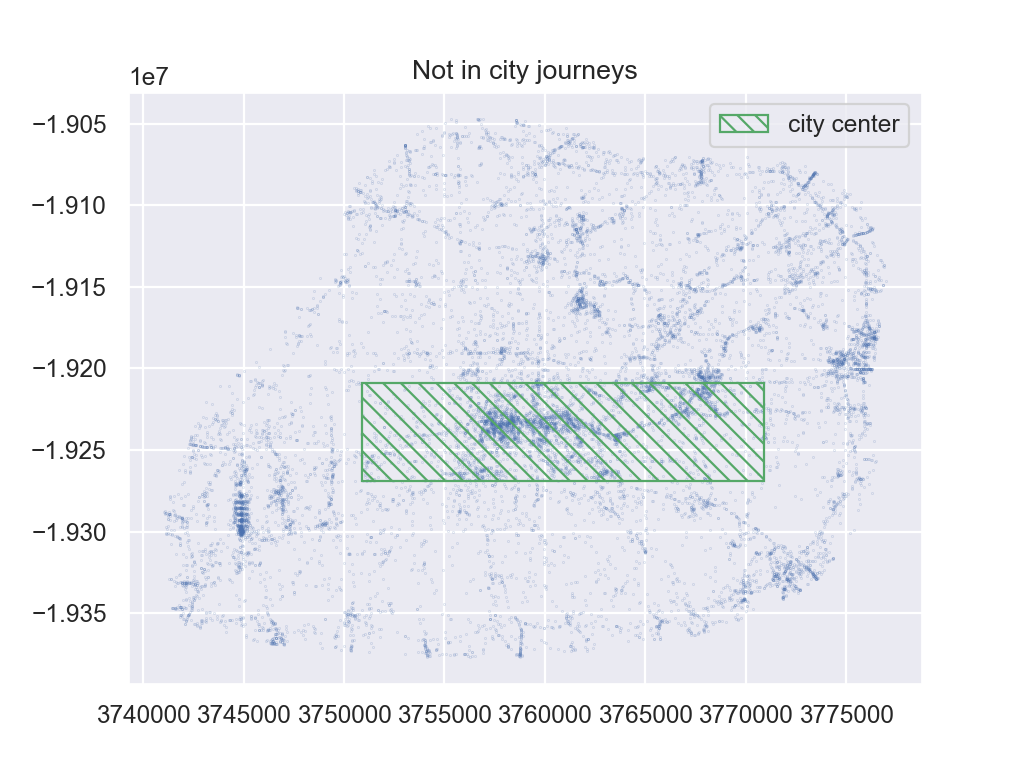

130967.07800245719 130967.07800245719 POINT (3770901.5068 -19208905.6133)


In [175]:
plt.clf()
plot_traj(train.loc[[266171]])

In [155]:
def plot_traj(row):
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                             (- 19268905.6133 + 19208905.6133),
                             linewidth=1,edgecolor='g',fill = False,hatch = '\\\\\\', label = 'city center')
    city = plt.gca().add_patch(rect)
#     arrows = plt.plot([row['x_entry'], row['x_exit']], [row['y_entry'], row['y_exit']], 
#                       label ='Trajectory', color = 'b')
    entries = plt.scatter(row['x_entry'],row['y_entry'], label='Entry point', color = 'b')
    exits = plt.scatter(row['x_exit'],row['y_exit'], label='Exit point', color = 'r')
    
    point = Point(row['x_entry'], row['y_entry'])
    pol_ext = LinearRing(poly.exterior.coords)
    d = pol_ext.project(point)
    p = pol_ext.interpolate(d)
    closest_point_coords = list(p.coords)[0]
    print(p.distance(point), poly.boundary.distance(point), p)
    
    cityClose = plt.scatter(closest_point_coords[0],closest_point_coords[1], label='closest boundary', color = 'y')
    plt.legend(handles=[city,entries, exits, cityClose])
    plt.grid(True)
    plt.show()

In [210]:
plt.clf()
plot_fig(train[train['label'] == 1])

<IPython.core.display.Javascript object>


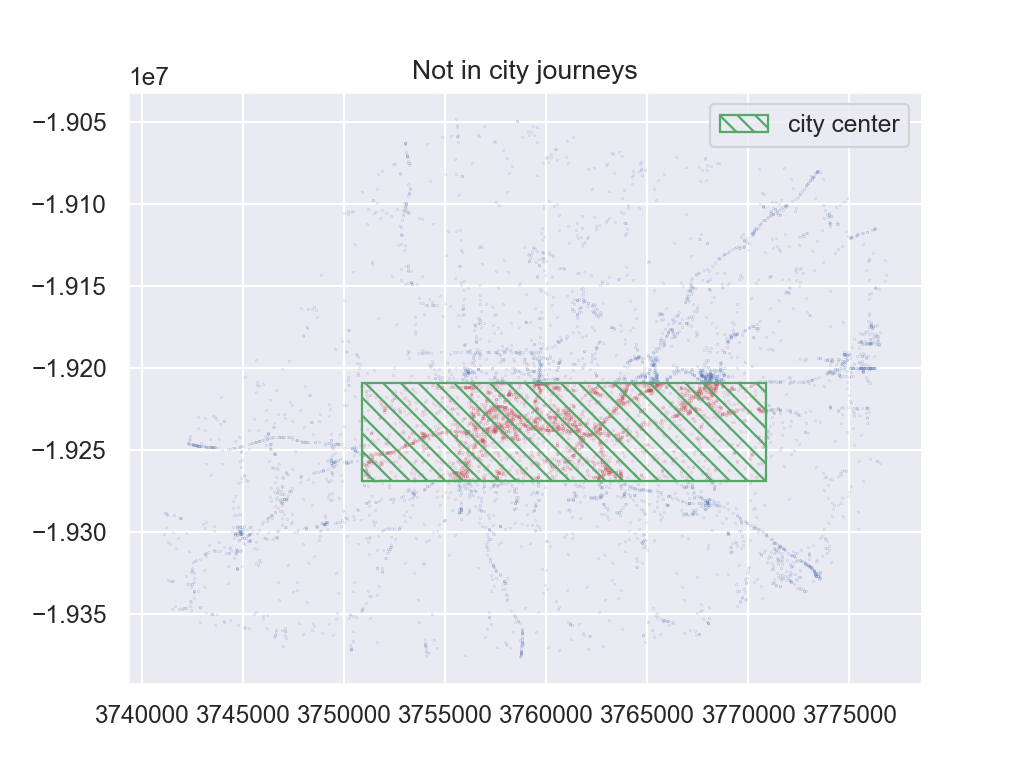

In [253]:
plt.clf()
plot_fig(train[(~((train['x_entry'] >= 3750901.5068) &
         (train['x_entry'] <= 3770901.5068) & (train['y_entry'] >= -19268905.6133) &
         (train['y_entry'] <= -19208905.6133))&(train['label'] == 1))])

In [225]:
test[~(((test['x_entry'] >= 3750901.5068) &
         (test['x_entry'] <= 3770901.5068)) & ((test['y_entry'] >= -19268905.6133) &
         (test['y_entry'] <= -19208905.6133)))].shape

(11991, 16)

In [221]:
test[((test['x_entry'] >= 3750901.5068) &
         (test['x_entry'] <= 3770901.5068)) & ((test['y_entry'] >= -19268905.6133) &
         (test['y_entry'] <= -19208905.6133))].shape

(4683, 16)

In [254]:
train[(~((train['x_entry'] >= 3750901.5068) &
         (train['x_entry'] <= 3770901.5068) & (train['y_entry'] >= -19268905.6133) &
         (train['y_entry'] <= -19208905.6133))&(train['label'] == 1))].shape[0]

3957

In [255]:
train[(~((train['x_entry'] >= 3750901.5068) &
         (train['x_entry'] <= 3770901.5068) & (train['y_entry'] >= -19268905.6133) &
         (train['y_entry'] <= -19208905.6133))&(train['label'] == 0))].shape[0]

44171

In [257]:
train[(((train['x_entry'] >= 3750901.5068) &
         (train['x_entry'] <= 3770901.5068) & (train['y_entry'] >= -19268905.6133) &
         (train['y_entry'] <= -19208905.6133))&(train['label'] == 0))].shape[0]

6026

In [258]:
train[(((train['x_entry'] >= 3750901.5068) &
         (train['x_entry'] <= 3770901.5068) & (train['y_entry'] >= -19268905.6133) &
         (train['y_entry'] <= -19208905.6133))&(train['label'] == 1))].shape[0]

12911

In [259]:
test.label.value_counts()

-1    16674
Name: label, dtype: int64

In [260]:
df_test['label']= -1
df_test['label'] = df_test.apply(lambda row: 1 
                                 if ((row['duration'] == 0.0)&(math.isnan(row['x_exit'])) & (math.isnan(row['y_exit'])) &
                                      (row['x_entry'] >= 3750901.5068) & (row['x_entry'] <= 3770901.5068) & 
                                      (row['y_entry'] >= -19268905.6133) & (row['y_entry'] <= -19208905.6133)) 
                                 else row['label'], axis=1)
df_test['label'] = df_test.apply(lambda row: 0 
                                 if ((row['duration'] == 0.0)&(math.isnan(row['x_exit'])) & (math.isnan(row['y_exit'])) &
                                     (row['label'] == -1))
                                 else row['label'], axis=1)

df_test['label'] = df_test.apply(lambda row: 0 
                                 if ((row['duration'] != 0.0)&(math.isnan(row['x_exit'])) &
                                     (math.isnan(row['y_exit'])) &
                                     (row['label'] == -1) &
                                     ~(((row['x_entry'] >= 3750901.5068) &
                                                               (row['x_entry'] <= 3770901.5068)) &
                                       ((row['y_entry'] >= -19268905.6133) &
                                        (row['y_entry'] <= -19208905.6133))))
                                 else row['label'], axis=1)
df_test['label'] = df_test.apply(lambda row: 1
                                 if ((row['duration'] != 0.0)&(math.isnan(row['x_exit'])) &
                                     (math.isnan(row['y_exit'])) &
                                     (row['label'] == -1) &
                                     (((row['x_entry'] >= 3750901.5068) &
                                                               (row['x_entry'] <= 3770901.5068)) &
                                       ((row['y_entry'] >= -19268905.6133) &
                                        (row['y_entry'] <= -19208905.6133))))
                                 else row['label'], axis=1)

In [270]:
df_test[(df_test['duration']!=0) & (df_test.x_exit.isnull())].label.value_counts()

0    11991
1     4683
Name: label, dtype: int64

In [265]:
df_test[df_test.x_exit.isnull()][['trajectory_id', 'label']].to_csv('output2.csv', index=False)

In [271]:
plt.clf()
plot_fig(train[(~((train['x_entry'] >= 3750901.5068) &
         (train['x_entry'] <= 3770901.5068) & (train['y_entry'] >= -19268905.6133) &
         (train['y_entry'] <= -19208905.6133))&(train['label'] == 1))])

0.3905429071803853